In [1]:
import os

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms


from config import Config
from model import PoseClassifier, VariationalAutoencoder
from train_vae import generate_pose
from vis_pose import vis_pose
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
image = None
copied_image = None

In [3]:

class InferenceModule(object):
    def __init__(self, cfg, classifier, vae):
        self.classifier = classifier
        self.vae = vae

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.cfg = cfg

        self.cluster_keypoints_list = []
        with open(os.path.join('./affordance_data', f'centers_30{self.cfg.data_tag}.txt'), 'r') as f:
            cluster_data_list = list(f.readlines())
        for cluster_data in cluster_data_list:
            cluster_data = cluster_data.split(' ')[:-1]
            cluster_data = [float(x) for x in cluster_data]
            cluster_keypoints = []
            for i in range(0, len(cluster_data), 2):
                cluster_keypoints.append((cluster_data[i], cluster_data[i+1]))
            cluster_keypoints = cluster_keypoints[:-1]
            self.cluster_keypoints_list.append(torch.tensor(cluster_keypoints))
        self.cluster_keypoints_list = torch.stack(self.cluster_keypoints_list)
    
    def inference(self, image, target_point):

        width, height = image.size
        crop_box = ((target_point[0] - (height // 2)), (target_point[1] - (height // 2)), (target_point[0] + (height // 2)), (target_point[1] + (height // 2)))
        zoom_box = ((target_point[0] - (height // 4)), (target_point[1] - (height // 4)), (target_point[0] + (height // 4)), (target_point[1] + (height // 4)))
        image_crop = image.crop(crop_box)
        image_zoom = image.crop(zoom_box)

        image_tensor = self.transform(image).unsqueeze(0)
        image_crop_tensor = self.transform(image_crop).unsqueeze(0)
        image_zoom_tensor = self.transform(image_zoom).unsqueeze(0)

        pose_label = self.classifier(image_tensor, image_crop_tensor, image_zoom_tensor)[0]
        pose_index = torch.argmax(pose_label)
        base_pose = self.cluster_keypoints_list[pose_index]
        one_hot_pose = [0.0] * pose_label.shape[0]
        one_hot_pose[pose_index] = 1.0
        one_hot_pose = torch.tensor(one_hot_pose).unsqueeze(0)

        latent_vector = torch.randn((1, self.cfg.latent_dim))

        sclae_deformation = self.vae.decoder(latent_vector, one_hot_pose, image_tensor, image_crop_tensor, image_zoom_tensor)
        scale = sclae_deformation[:, :2]
        deformation = sclae_deformation[:, 2:]

        pose = generate_pose(base_pose.unsqueeze(0), scale, deformation, torch.tensor(target_point).unsqueeze(0))
        base_pose = generate_pose(base_pose.unsqueeze(0), scale, torch.zeros(deformation.size()), torch.tensor(target_point).unsqueeze(0))
        return pose, base_pose


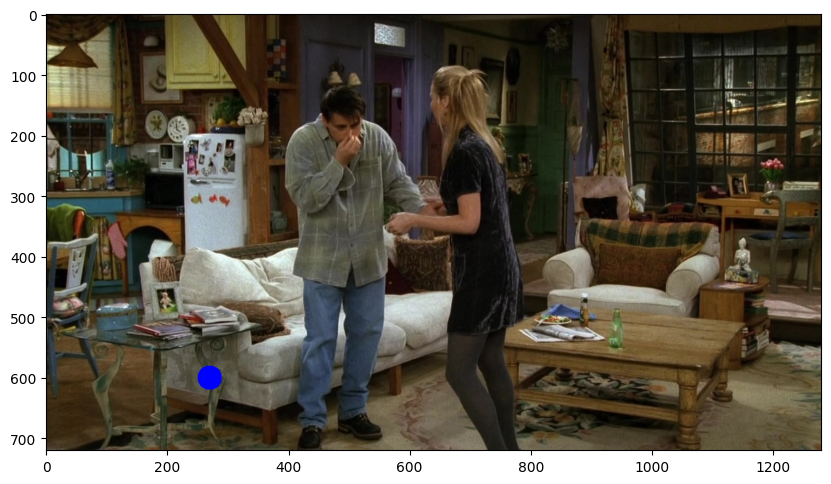

In [27]:
device = 'cpu'

cfg = Config()
classifier = PoseClassifier(cfg).to(device)
vae = VariationalAutoencoder(cfg).to(device)


classifier_checkpoint = 'checkpoints/experiment31/model_2_3_[0.10284237563610077, 0.17209301888942719, 0.23850128054618835, 0.29586562514305115, 0.35116276144981384].pt'
vae_checkpoint = 'checkpoints/experiment31/model_70_813_706.pt'

classifier.load_state_dict(torch.load(classifier_checkpoint, map_location='cpu'))
vae.load_state_dict(torch.load(vae_checkpoint, map_location='cpu'))

model = InferenceModule(cfg, classifier, vae)


image_path = 'test/test.jpg'
target_point = (270, 600)

image = Image.open(image_path)
pose, base_pose = model.inference(image, target_point)
pose = pose[0].tolist()
base_pose = base_pose[0].tolist()
pose = [(round(x[0]), round(x[1])) for x in pose]
base_pose = [(round(x[0]), round(x[1])) for x in base_pose]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
copied_image = image.copy()
cv2.circle(copied_image, target_point, 20, (0, 0, 255), -1)
plt.imshow(copied_image)
plt.show()

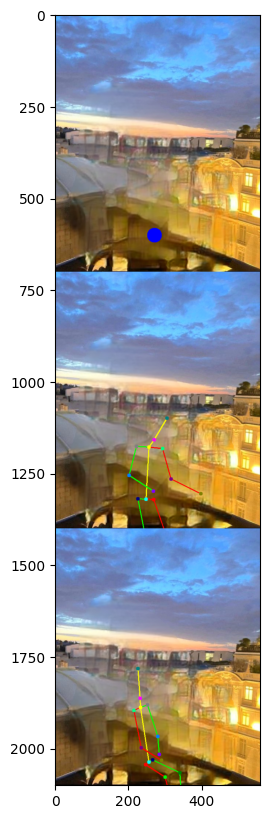

In [26]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
copied_image = image.copy()
cv2.circle(copied_image, target_point, 20, (0, 0, 255), -1)

base_pose_image = vis_pose(image_path, base_pose, show=False)
base_pose_image = cv2.cvtColor(base_pose_image, cv2.COLOR_BGR2RGB)

pose_image = vis_pose(image_path, pose, show=False)
pose_image = cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB)

plot_image = cv2.vconcat([copied_image, base_pose_image, pose_image])
plt.imshow(plot_image)
plt.show()

In [46]:
with open('./affordance_data/testlist.txt', 'r') as f:
    test_data_list = list(f.readlines())
test_image_list = [x.split(' ')[0] for x in test_data_list]
import random
test_image_name = random.sample(test_image_list, 1)[0]

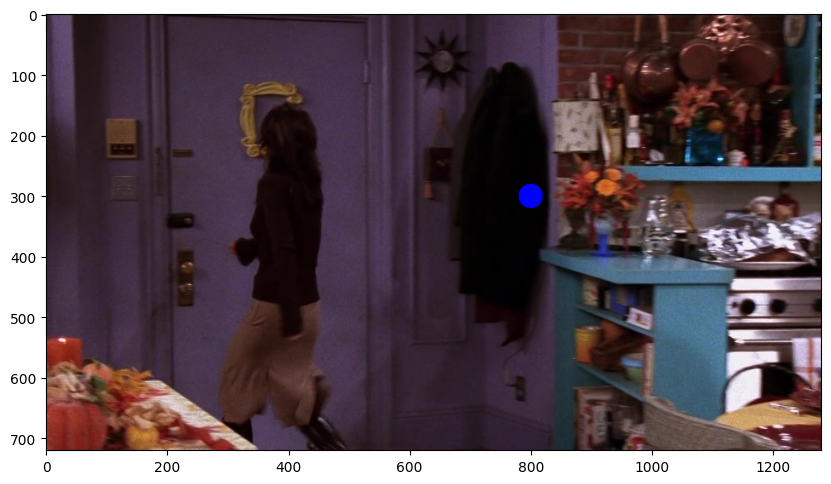

In [50]:
test_image_dir_path = './affordance_data/data'
image_path = os.path.join(test_image_dir_path, test_image_name)
target_point = (800, 300)

image = Image.open(image_path)
pose, base_pose = model.inference(image, target_point)
pose = pose[0].tolist()
base_pose = base_pose[0].tolist()
pose = [(round(x[0]), round(x[1])) for x in pose]
base_pose = [(round(x[0]), round(x[1])) for x in base_pose]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
copied_image = image.copy()
cv2.circle(copied_image, target_point, 20, (0, 0, 255), -1)
plt.imshow(copied_image)
plt.show()

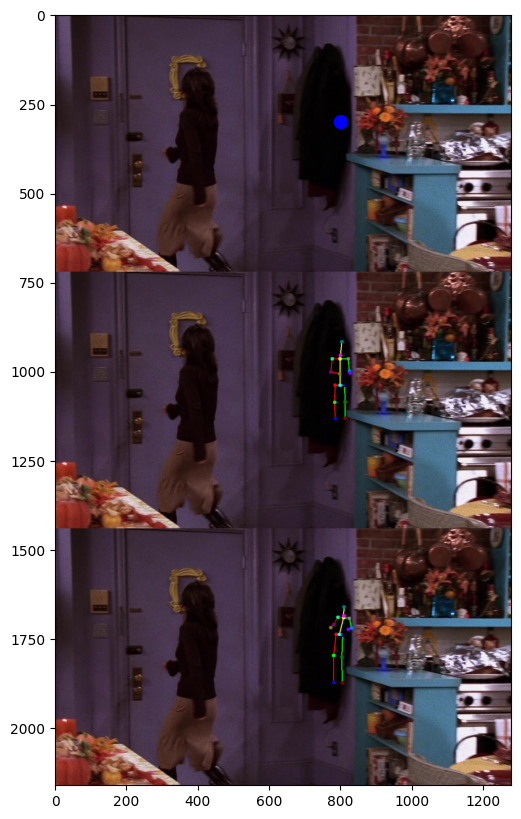

In [51]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
copied_image = image.copy()
cv2.circle(copied_image, target_point, 20, (0, 0, 255), -1)

base_pose_image = vis_pose(image_path, base_pose, show=False)
base_pose_image = cv2.cvtColor(base_pose_image, cv2.COLOR_BGR2RGB)

pose_image = vis_pose(image_path, pose, show=False)
pose_image = cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB)

plot_image = cv2.vconcat([copied_image, base_pose_image, pose_image])
plt.imshow(plot_image)
plt.show()